In [13]:
#  Import required libraries
import pandas as pd
import numpy as np

import os
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score

In [14]:
# Set file paths for the dataset and metadata
data_path = "wdbc.data"
meta_path = "wdbc.names"

# Try reading the metadata file to understand the dataset a bit better
try:
    with open(meta_path, "r") as f:
        print("Metadata:\n")
        print(f.read())
except FileNotFoundError:
    print("Could not find the metadata file (wdbc.names).")

# Define column names based on what I found in the dataset documentation
columns = ['ID', 'Diagnosis'] + [f'Feature_{i}' for i in range(1, 31)]

# Load the dataset
cancer_data = pd.read_csv(data_path, header=None, names=columns)

# The ID column doesn't help with analysis or modeling, so I'm dropping it
cancer_data.drop(columns=['ID'], inplace=True)

# Convert diagnosis values: 'M' for malignant becomes 1, 'B' for benign becomes 0
cancer_data['Diagnosis'] = cancer_data['Diagnosis'].map({'M': 1, 'B': 0})

Metadata:

1. Title: Wisconsin Diagnostic Breast Cancer (WDBC)

2. Source Information

a) Creators: 

	Dr. William H. Wolberg, General Surgery Dept., University of
	Wisconsin,  Clinical Sciences Center, Madison, WI 53792
	wolberg@eagle.surgery.wisc.edu

	W. Nick Street, Computer Sciences Dept., University of
	Wisconsin, 1210 West Dayton St., Madison, WI 53706
	street@cs.wisc.edu  608-262-6619

	Olvi L. Mangasarian, Computer Sciences Dept., University of
	Wisconsin, 1210 West Dayton St., Madison, WI 53706
	olvi@cs.wisc.edu 

b) Donor: Nick Street

c) Date: November 1995

3. Past Usage:

first usage:

	W.N. Street, W.H. Wolberg and O.L. Mangasarian 
	Nuclear feature extraction for breast tumor diagnosis.
	IS&T/SPIE 1993 International Symposium on Electronic Imaging: Science
	and Technology, volume 1905, pages 861-870, San Jose, CA, 1993.

OR literature:

	O.L. Mangasarian, W.N. Street and W.H. Wolberg. 
	Breast cancer diagnosis and prognosis via linear programming. 
	Operations Research,

In [59]:
# Display the first few rows to get a quick look at the data
print("\nFirst few rows of the dataset:\n")
cancer_data.head()


First few rows of the dataset:



,Diagnosis,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Feature_21,Feature_22,Feature_23,Feature_24,Feature_25,Feature_26,Feature_27,Feature_28,Feature_29,Feature_30
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [16]:
# Show basic info about the dataset
print("\nDataset info:\n")
cancer_data.info()


Dataset info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Diagnosis   569 non-null    int64  
 1   Feature_1   569 non-null    float64
 2   Feature_2   569 non-null    float64
 3   Feature_3   569 non-null    float64
 4   Feature_4   569 non-null    float64
 5   Feature_5   569 non-null    float64
 6   Feature_6   569 non-null    float64
 7   Feature_7   569 non-null    float64
 8   Feature_8   569 non-null    float64
 9   Feature_9   569 non-null    float64
 10  Feature_10  569 non-null    float64
 11  Feature_11  569 non-null    float64
 12  Feature_12  569 non-null    float64
 13  Feature_13  569 non-null    float64
 14  Feature_14  569 non-null    float64
 15  Feature_15  569 non-null    float64
 16  Feature_16  569 non-null    float64
 17  Feature_17  569 non-null    float64
 18  Feature_18  569 non-null    float64
 19  Feature_19  5

In [17]:
# Display basic statistics for numerical columns
print("\nSummary statistics:\n")
cancer_data.describe()


Summary statistics:



,Diagnosis,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Feature_21,Feature_22,Feature_23,Feature_24,Feature_25,Feature_26,Feature_27,Feature_28,Feature_29,Feature_30
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [18]:
# Check for missing values
cancer_data.isnull().sum()

,0
Diagnosis,0
Feature_1,0
Feature_2,0
Feature_3,0
Feature_4,0
Feature_5,0
Feature_6,0
Feature_7,0
Feature_8,0
Feature_9,0


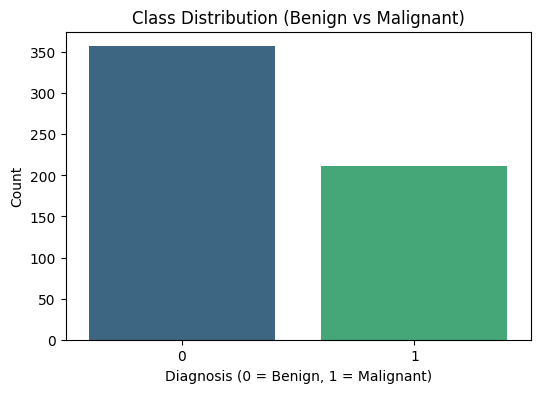

In [65]:
plt.figure(figsize=(6, 4))
sns.countplot(x=cancer_data['Diagnosis'], hue=cancer_data['Diagnosis'], palette='viridis', legend=False)
plt.title('Class Distribution (Benign vs Malignant)')
plt.xlabel('Diagnosis (0 = Benign, 1 = Malignant)')
plt.ylabel('Count')
plt.show()

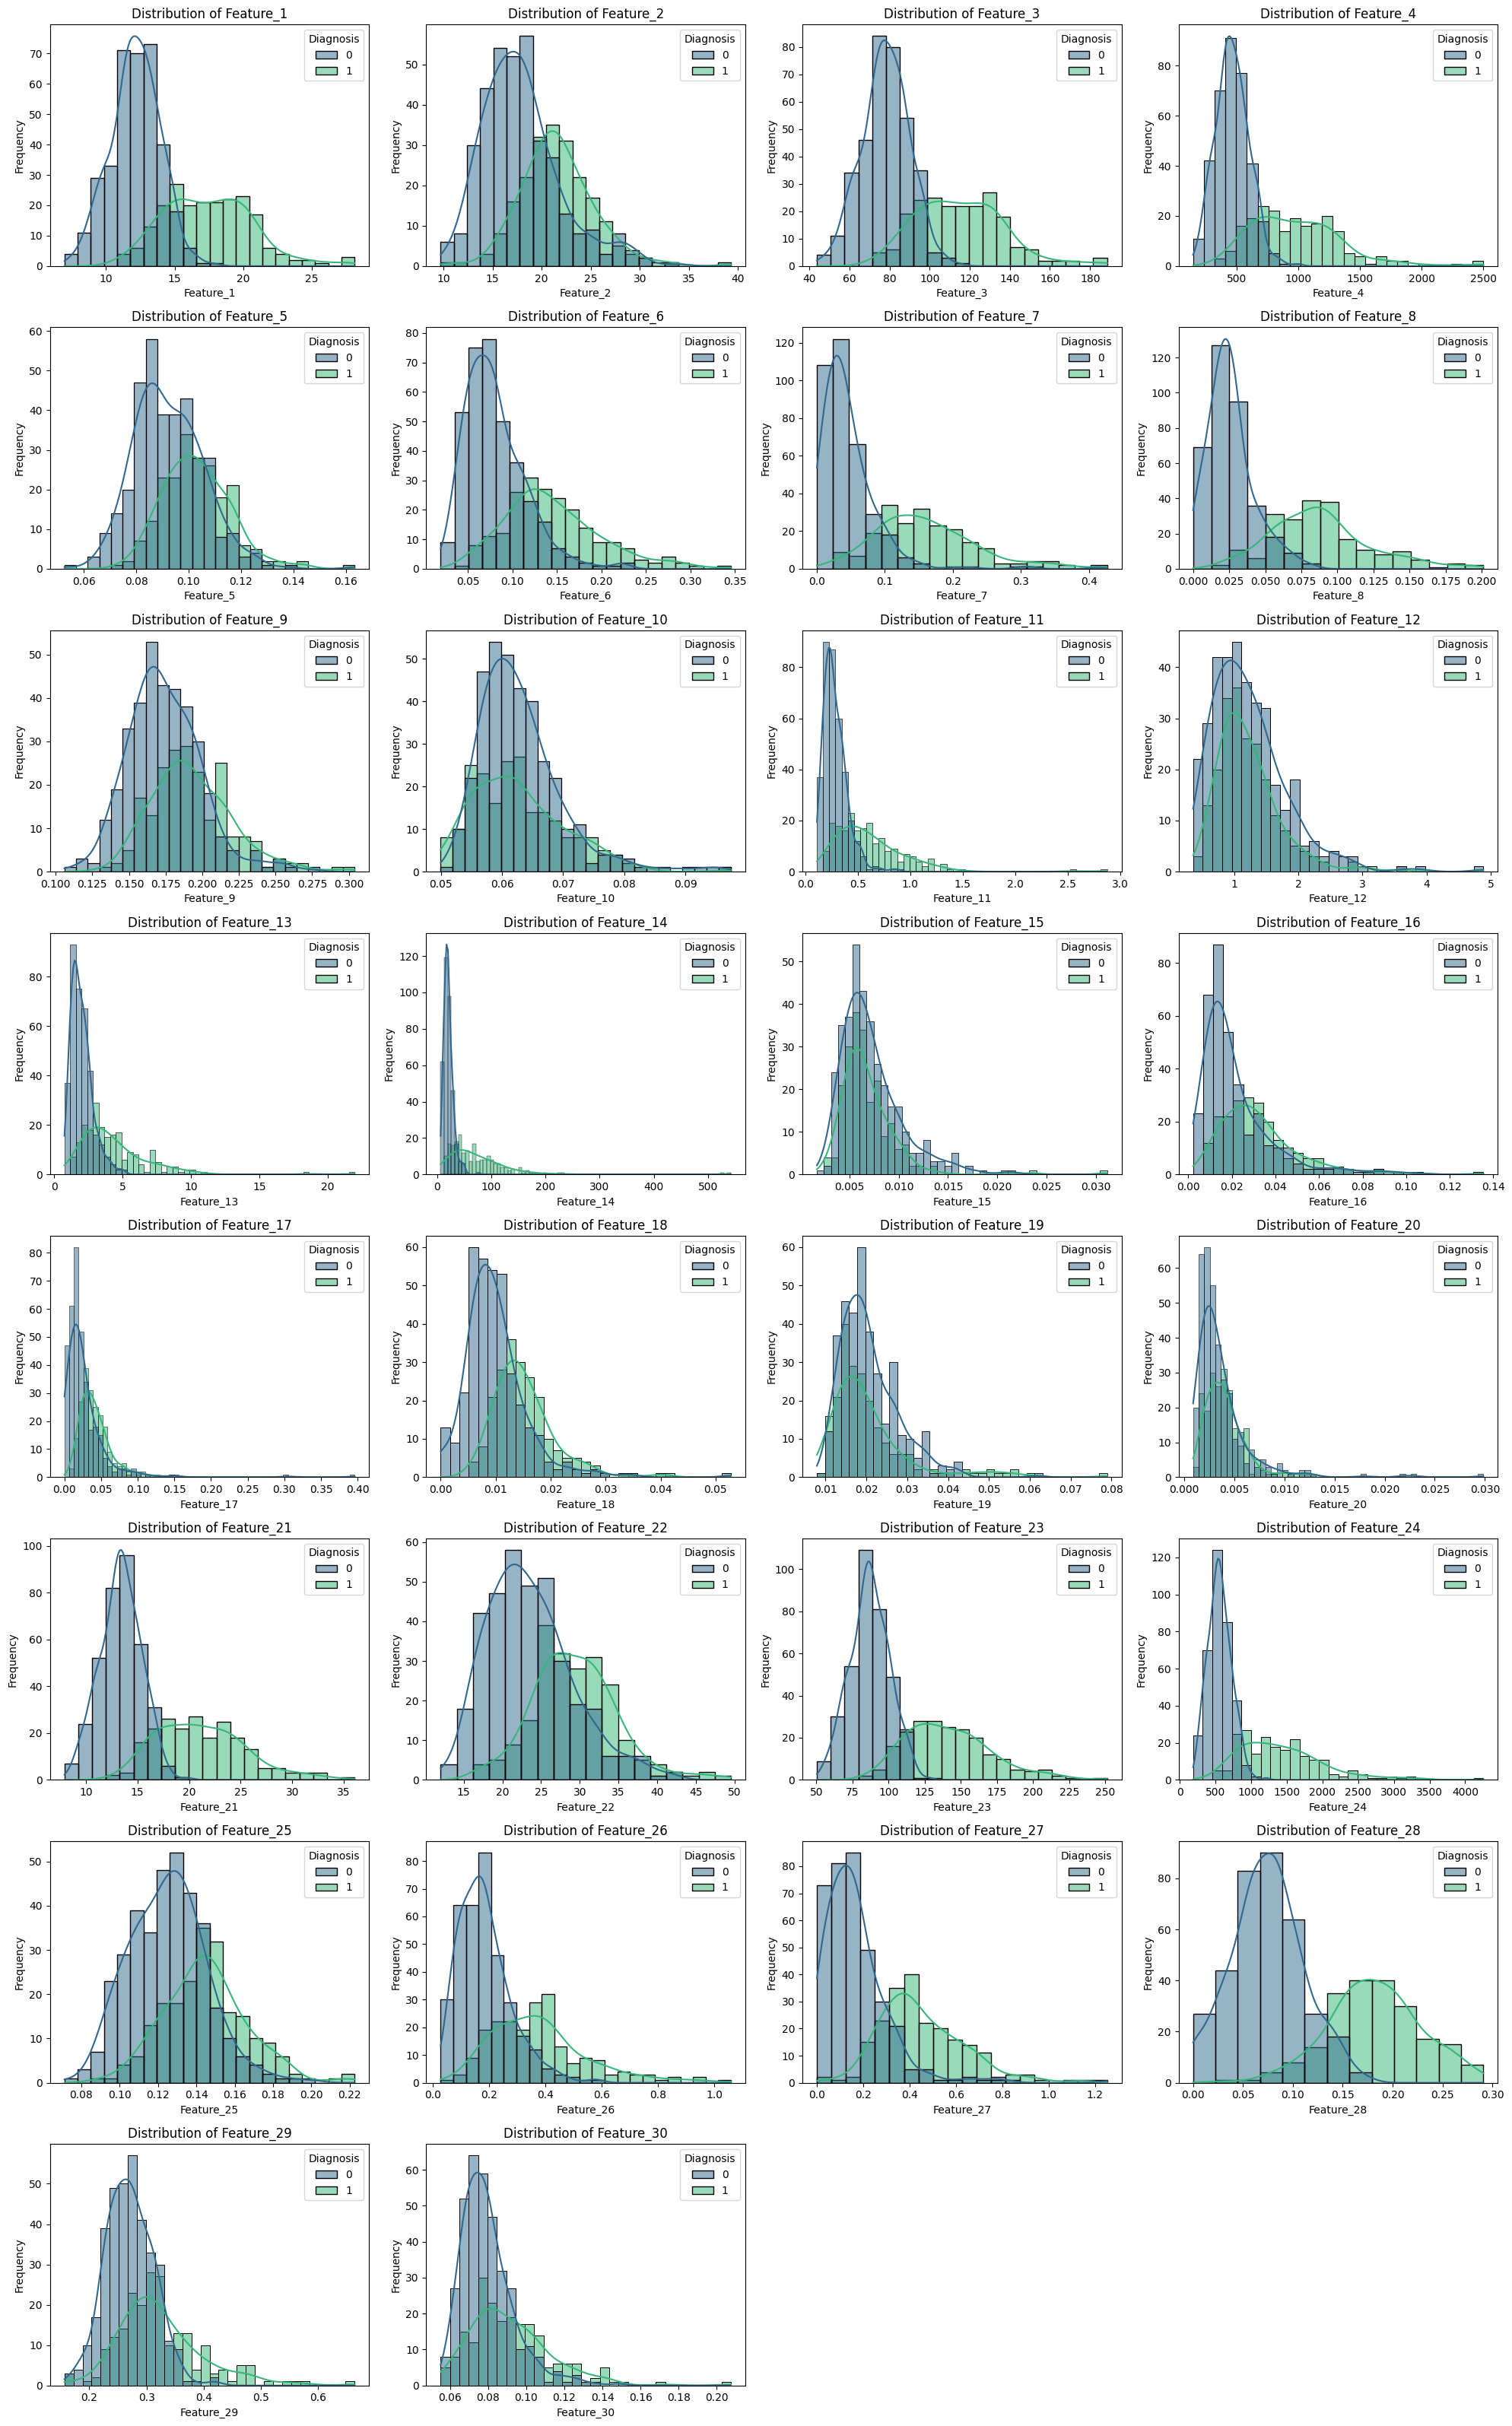

In [64]:
features_to_plot_range = [f'Feature_{i}' for i in range(1, 31)] # All 30 features

# Determine the number of rows and columns for subplots
n_features = len(features_to_plot_range)
n_cols = 4  # You can adjust the number of columns as needed
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten() # Flatten the 2D array of axes for easier iteration

for i, feature in enumerate(features_to_plot_range):
    sns.histplot(data=cancer_data, x=feature, hue='Diagnosis', kde=True, palette='viridis', ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

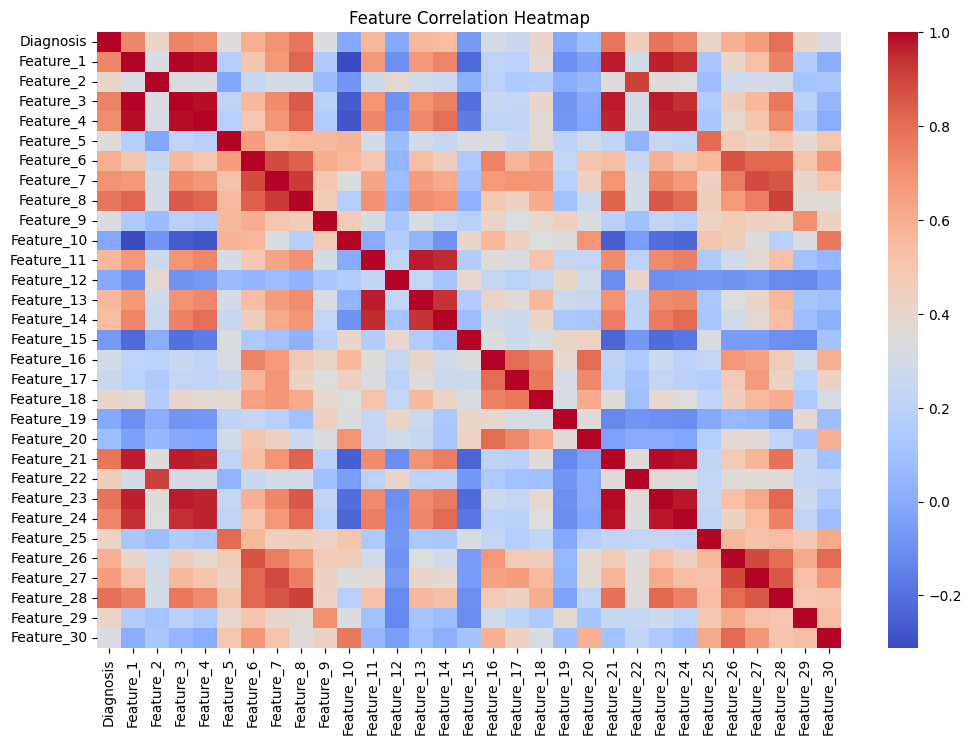

In [20]:
# Display heatmap of feature correlations
plt.figure(figsize=(12, 8))
sns.heatmap(cancer_data.corr(), cmap='coolwarm', annot=False)
plt.title('Feature Correlation Heatmap')
plt.show()

In [21]:
#  Split dataset into features  x and y
X = cancer_data.drop(columns=['Diagnosis'])
y = cancer_data['Diagnosis']

# Split into 80 percent  training and 20 percent  testing data
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

print(f"Training Samples: {len(X_train)}, Testing Samples: {len(X_test)}")

Training Samples: 455, Testing Samples: 114


In [22]:
#Standardize the feature data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [23]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score
from sklearn.metrics import recall_score, confusion_matrix, classification_report

#Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
rf_pred = rf_model.predict(X_test_scaled)

# Evaluate Random Forest Classifier
rf_acc = accuracy_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred)
rf_auc = roc_auc_score(y_test, rf_pred)
rf_precision = precision_score(y_test, rf_pred)
rf_recall = recall_score(y_test, rf_pred)

print(f'Random Forest Accuracy: {rf_acc:.4f}')
print(f'Random Forest F1 Score: {rf_f1:.4f}')
print(f'Random Forest AUC Score: {rf_auc:.4f}')
print(f'Random Forest Precision: {rf_precision:.4f}')
print(f'Random Forest Recall: {rf_recall:.4f}')

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, rf_pred))

Random Forest Accuracy: 0.9649
Random Forest F1 Score: 0.9524
Random Forest AUC Score: 0.9581
Random Forest Precision: 0.9756
Random Forest Recall: 0.9302

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        71
           1       0.98      0.93      0.95        43

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



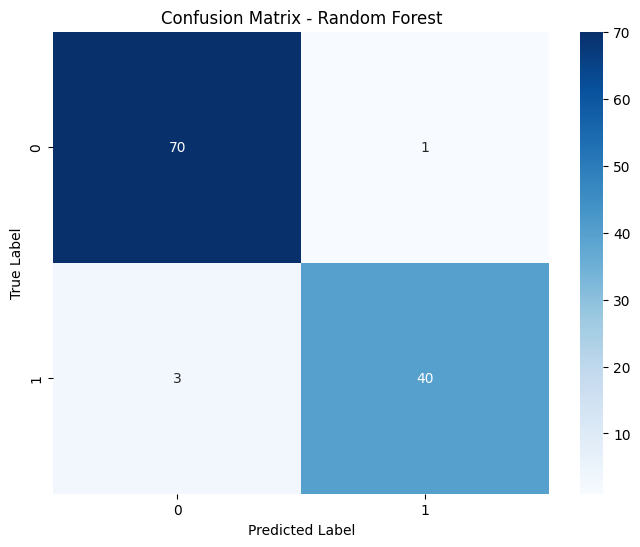

In [67]:
# Generate confusion matrix
rf_cm = confusion_matrix(y_test, rf_pred)

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(rf_cm, annot=True, fmt='d',
            cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

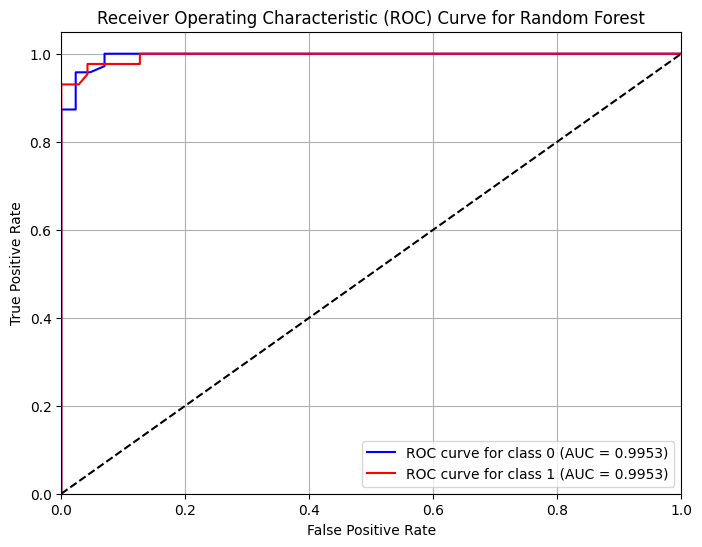

In [38]:
from sklearn.metrics import roc_curve, auc

# Get prediction probabilities for each class
y_pred_proba = rf_model.predict_proba(X_test_scaled)

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred_proba[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))

colors = ['blue', 'red']
for i in range(2):
    plt.plot(fpr[i], tpr[i], color=colors[i], label=f'ROC curve for class {i} (AUC = {roc_auc[i]:.4f})')

plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Random Forest')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

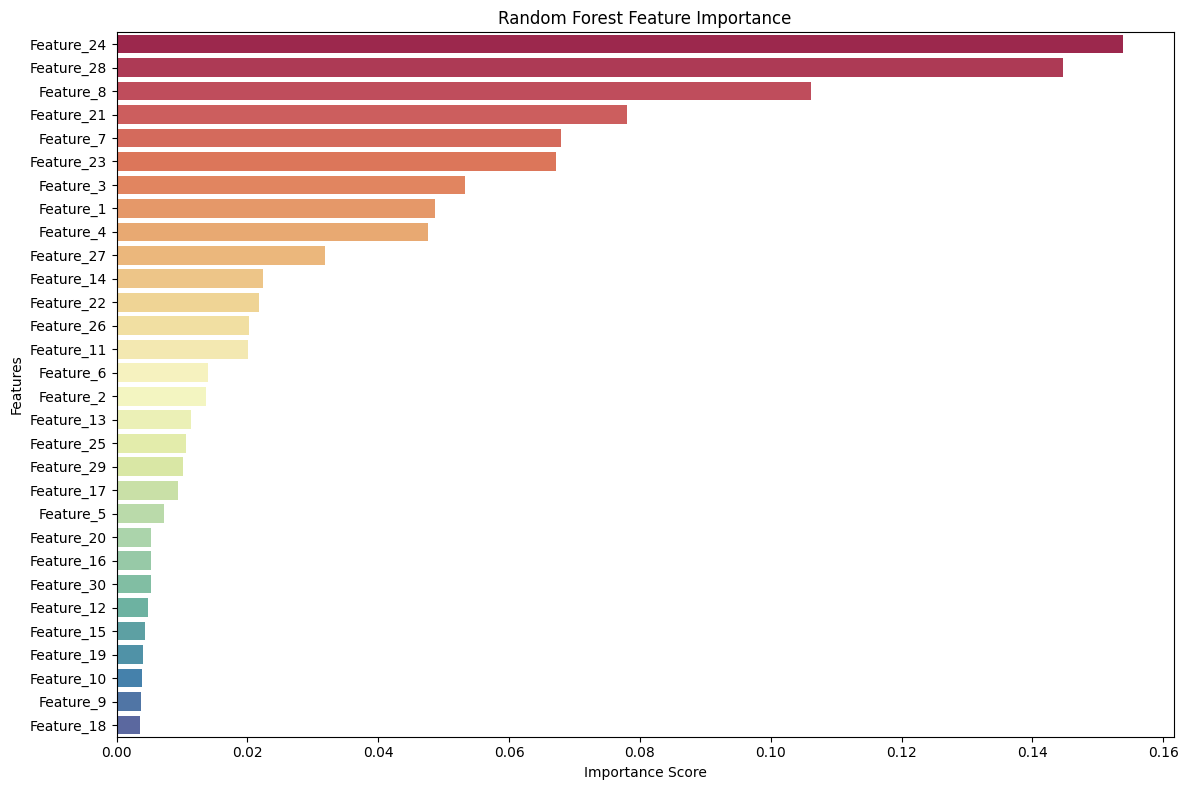

In [40]:
# Plotting Feature Importance for Random Forest Classifier
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importances, y=feature_importances.index, palette='Spectral')
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

In [31]:
#Train an SVM model
svm_model = SVC(kernel='linear', C=1.0, random_state=42, probability=True)
svm_model.fit(X_train_scaled, y_train)

# Make predictions
svm_pred = svm_model.predict(X_test_scaled)

# Evaluate SVM
svm_acc = accuracy_score(y_test, svm_pred)
svm_f1 = f1_score(y_test, svm_pred)
svm_auc = roc_auc_score(y_test, svm_pred)
svm_precision = precision_score(y_test, svm_pred)
svm_recall = recall_score(y_test, svm_pred)

print(f'SVM Accuracy: {svm_acc:.4f}')
print(f'SVM F1 Score: {svm_f1:.4f}')
print(f'SVM AUC Score: {svm_auc:.4f}')
print(f'SVM Precision: {svm_precision:.4f}')
print(f'SVM Recall: {svm_recall:.4f}')

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, svm_pred))

SVM Accuracy: 0.9561
SVM F1 Score: 0.9425
SVM AUC Score: 0.9556
SVM Precision: 0.9318
SVM Recall: 0.9535

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96        71
           1       0.93      0.95      0.94        43

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114



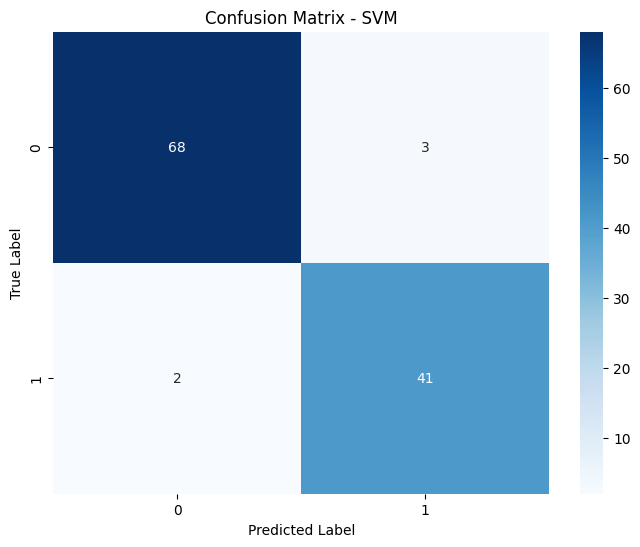

In [32]:
# Generate confusion matrix for SVM
svm_cm = confusion_matrix(y_test, svm_pred)

# Display the confusion matrix for SVM
plt.figure(figsize=(8, 6))
sns.heatmap(svm_cm, annot=True, fmt='d',
            cmap='Blues')
plt.title('Confusion Matrix - SVM')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

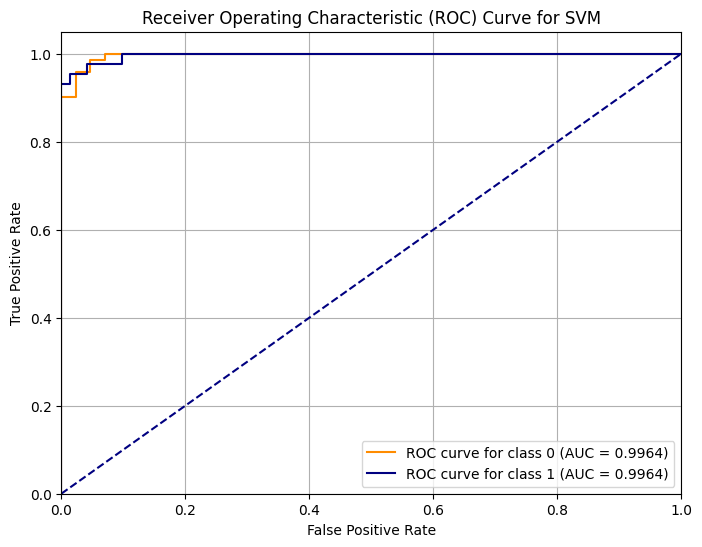

In [34]:
# Get probability estimates for each class
y_pred_proba_svm = svm_model.predict_proba(X_test_scaled)

# Compute ROC curve and AUC for each class
fpr_svm = {}
tpr_svm = {}
roc_auc_svm = {}

for i in range(2):
    fpr_svm[i], tpr_svm[i], _ = roc_curve(y_test, y_pred_proba_svm[:, i], pos_label=i)
    roc_auc_svm[i] = auc(fpr_svm[i], tpr_svm[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))

colors = ['darkorange', 'navy']
for i in range(2):
    plt.plot(fpr_svm[i], tpr_svm[i], color=colors[i], label=f'ROC curve for class {i} (AUC = {roc_auc_svm[i]:.4f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for SVM')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

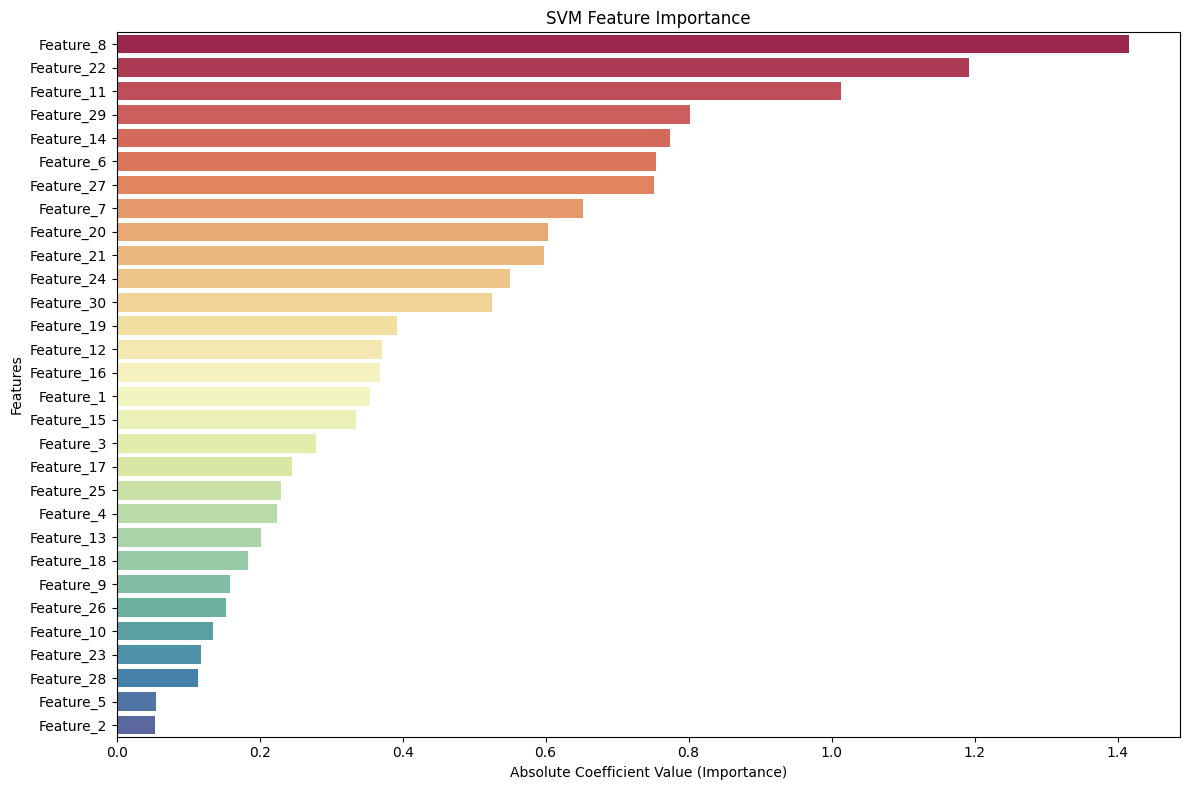

In [42]:
svm_feature_importance = pd.Series(np.abs(svm_model.coef_[0]), index=X.columns)
svm_feature_importance.sort_values(ascending=False, inplace=True)

# Plotting Feature Importance for SVM Classifier
plt.figure(figsize=(12, 8))
# Assign y to hue and set legend=False as suggested by the FutureWarning
sns.barplot(x=svm_feature_importance, y=svm_feature_importance.index, palette='Spectral', hue=svm_feature_importance.index, legend=False)
plt.title('SVM Feature Importance')
plt.xlabel('Absolute Coefficient Value (Importance)')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

In [35]:
#  Train a Logistic Regression model
lr_model = LogisticRegression()
lr_model.fit(X_train_scaled, y_train)

# Make predictions
lr_pred = lr_model.predict(X_test_scaled)

# Evaluate Logistic Regression
lr_acc = accuracy_score(y_test, lr_pred)
lr_f1 = f1_score(y_test, lr_pred)
lr_auc = roc_auc_score(y_test, lr_pred)
lr_precision = precision_score(y_test, lr_pred)
lr_recall = recall_score(y_test, lr_pred)

print(f'Logistic Regression Accuracy: {lr_acc:.4f}')
print(f'Logistic Regression F1 Score: {lr_f1:.4f}')
print(f'Logistic Regression AUC Score: {lr_auc:.4f}')
print(f'Logistic Regression Precision: {lr_precision:.4f}')
print(f'Logistic Regression Recall: {lr_recall:.4f}')

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, lr_pred))

Logistic Regression Accuracy: 0.9737
Logistic Regression F1 Score: 0.9647
Logistic Regression AUC Score: 0.9697
Logistic Regression Precision: 0.9762
Logistic Regression Recall: 0.9535

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        71
           1       0.98      0.95      0.96        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



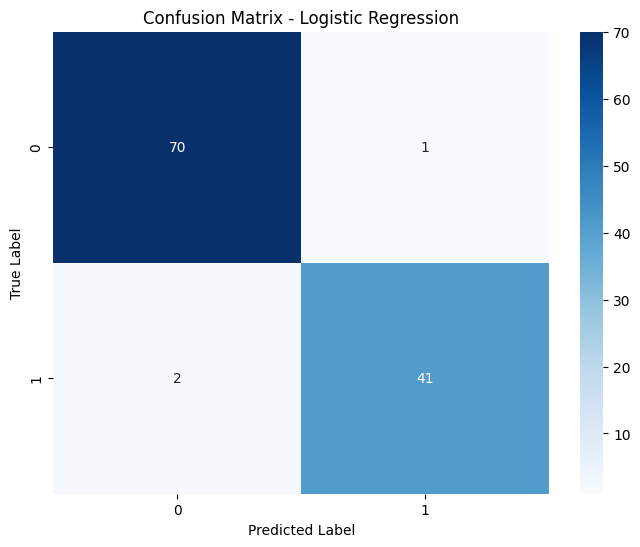

In [36]:
# Generate confusion matrix for Logistic Regression
lr_cm = confusion_matrix(y_test, lr_pred)

# Display the confusion matrix for Logistic Regression
plt.figure(figsize=(8, 6))
sns.heatmap(lr_cm, annot=True, fmt='d',
            cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

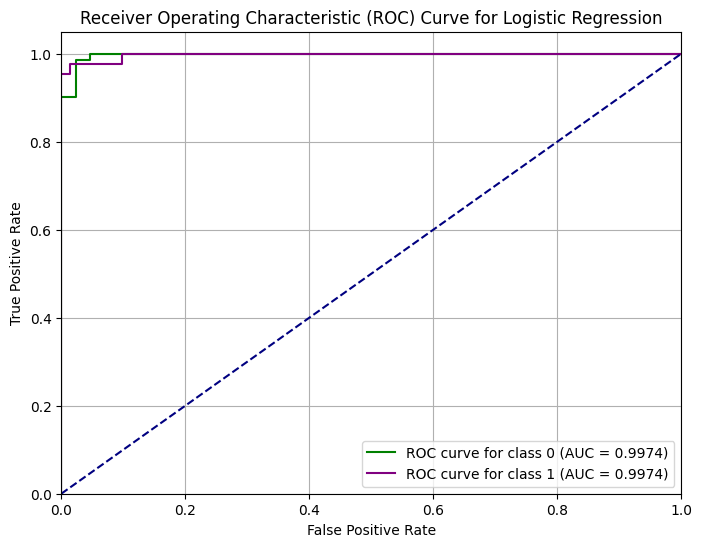

In [37]:
# Get probability estimates for each class for Logistic Regression
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)

# Compute ROC curve and AUC for each class
fpr_lr = {}
tpr_lr = {}
roc_auc_lr = {}

for i in range(2):
    fpr_lr[i], tpr_lr[i], _ = roc_curve(y_test, y_pred_proba_lr[:, i], pos_label=i)
    roc_auc_lr[i] = auc(fpr_lr[i], tpr_lr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))

colors = ['green', 'purple']
for i in range(2):
    plt.plot(fpr_lr[i], tpr_lr[i], color=colors[i], label=f'ROC curve for class {i} (AUC = {roc_auc_lr[i]:.4f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Logistic Regression')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

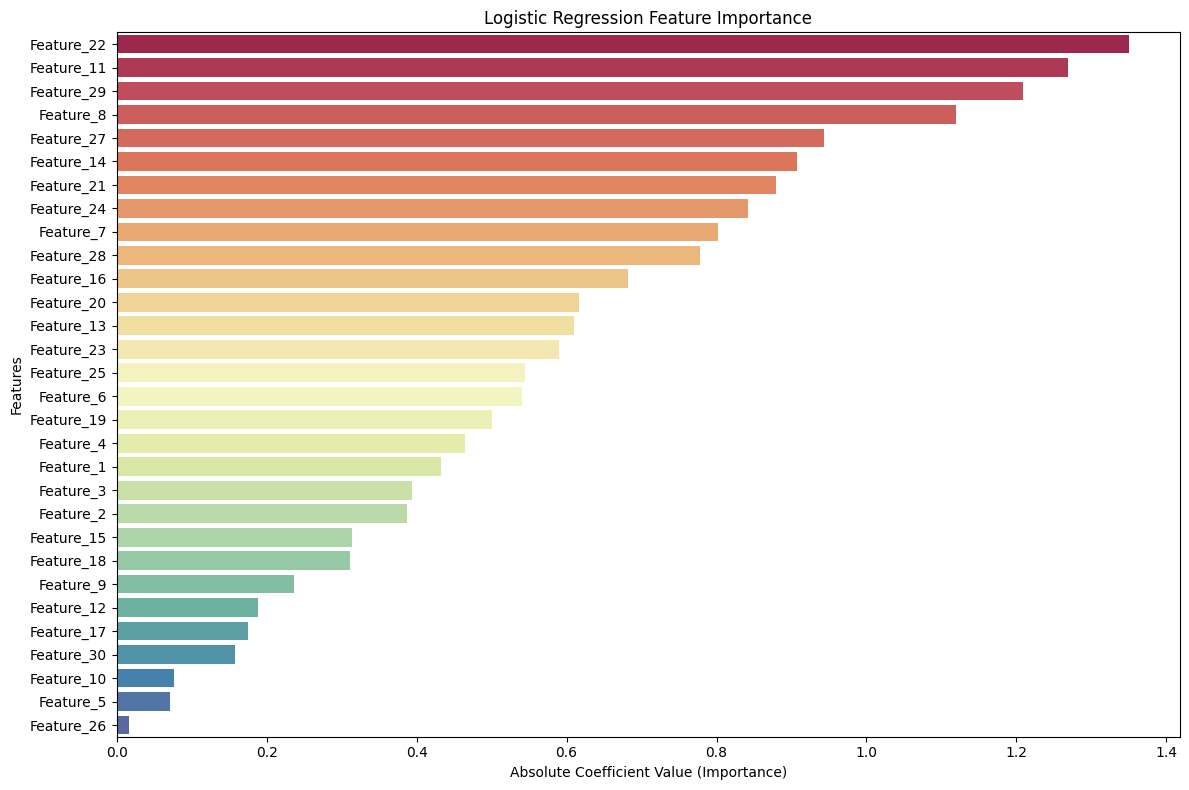

In [43]:
# Get absolute coefficient values as a measure of feature importance
lr_feature_importance = pd.Series(np.abs(lr_model.coef_[0]), index=X.columns)
lr_feature_importance.sort_values(ascending=False, inplace=True)

# Plotting Feature Importance for Logistic Regression using Spectral palette
plt.figure(figsize=(12, 8))
sns.barplot(x=lr_feature_importance, y=lr_feature_importance.index,
            palette='Spectral', hue=lr_feature_importance.index,
            legend=False)
plt.title('Logistic Regression Feature Importance')
plt.xlabel('Absolute Coefficient Value (Importance)')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

In [44]:
from sklearn.ensemble import GradientBoostingClassifier

# Train a Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=100,
                                      learning_rate=0.1,
                                      max_depth=3,
                                      random_state=42)
gb_model.fit(X_train_scaled, y_train)

# Make predictions
gb_pred = gb_model.predict(X_test_scaled)

# Evaluate Gradient Boosting
gb_acc = accuracy_score(y_test, gb_pred)
gb_f1 = f1_score(y_test, gb_pred)
gb_auc = roc_auc_score(y_test, gb_pred)
gb_precision = precision_score(y_test, gb_pred)
gb_recall = recall_score(y_test, gb_pred)

print(f'Gradient Boosting Accuracy: {gb_acc:.4f}')
print(f'Gradient Boosting F1 Score: {gb_f1:.4f}')
print(f'Gradient Boosting AUC Score: {gb_auc:.4f}')
print(f'Gradient Boosting Precision: {gb_precision:.4f}')
print(f'Gradient Boosting Recall: {gb_recall:.4f}')

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, gb_pred))

Gradient Boosting Accuracy: 0.9561
Gradient Boosting F1 Score: 0.9412
Gradient Boosting AUC Score: 0.9510
Gradient Boosting Precision: 0.9524
Gradient Boosting Recall: 0.9302

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97        71
           1       0.95      0.93      0.94        43

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



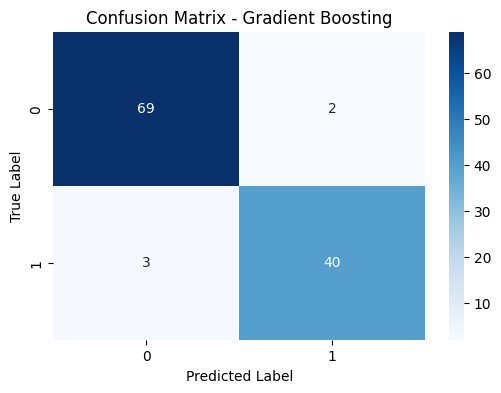

In [47]:
# Generate confusion matrix for Gradient Boosting
gb_cm = confusion_matrix(y_test, gb_pred)

# Display the confusion matrix for Gradient Boosting
plt.figure(figsize=(6, 4))
sns.heatmap(gb_cm, annot=True, fmt='d',
            cmap='Blues')
plt.title('Confusion Matrix - Gradient Boosting')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

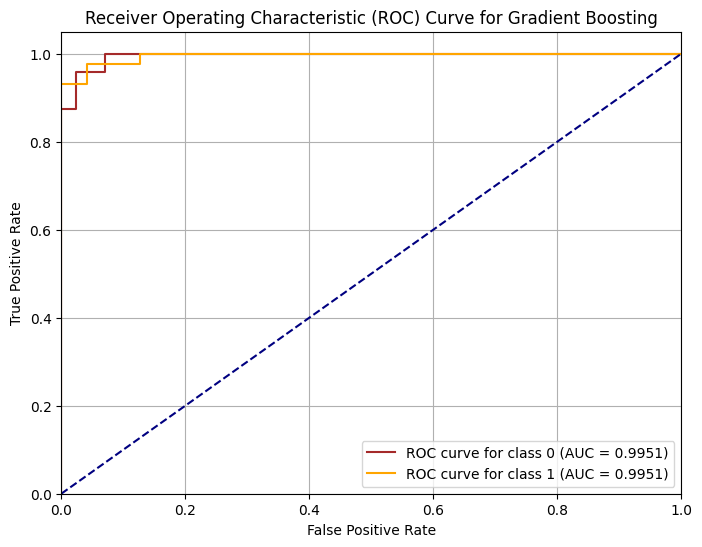

In [48]:
# Get probability estimates for each class for Gradient Boosting
y_pred_proba_gb = gb_model.predict_proba(X_test_scaled)

# Compute ROC curve and AUC for each class
fpr_gb = {}
tpr_gb = {}
roc_auc_gb = {}

for i in range(2):
    fpr_gb[i], tpr_gb[i], _ = roc_curve(y_test, y_pred_proba_gb[:, i], pos_label=i)
    roc_auc_gb[i] = auc(fpr_gb[i], tpr_gb[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))

colors = ['brown', 'orange']
for i in range(2):
    plt.plot(fpr_gb[i], tpr_gb[i], color=colors[i], label=f'ROC curve for class {i} (AUC = {roc_auc_gb[i]:.4f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Gradient Boosting')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

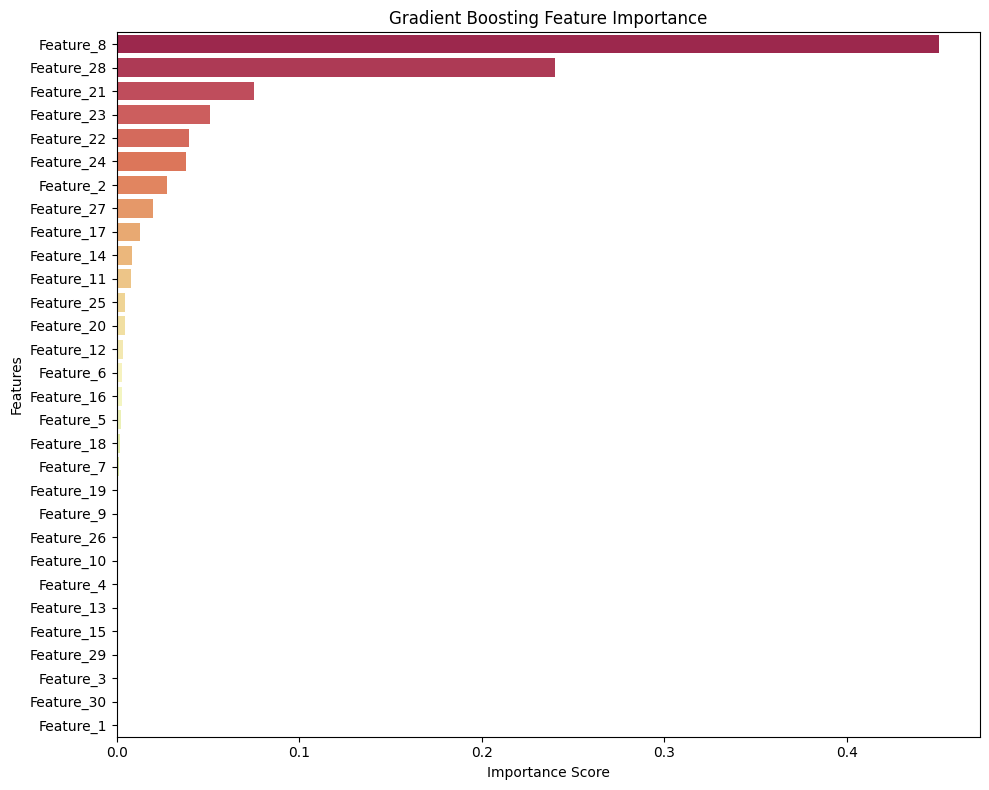

In [50]:
# Plotting Feature Importance for Gradient Boosting Classifier
gb_feature_importance = pd.Series(gb_model.feature_importances_,
                                  index=X.columns)
gb_feature_importance.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(10, 8))
sns.barplot(x=gb_feature_importance, y=gb_feature_importance.index,
            palette='Spectral', hue=gb_feature_importance.index,
            legend=False)
plt.title('Gradient Boosting Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

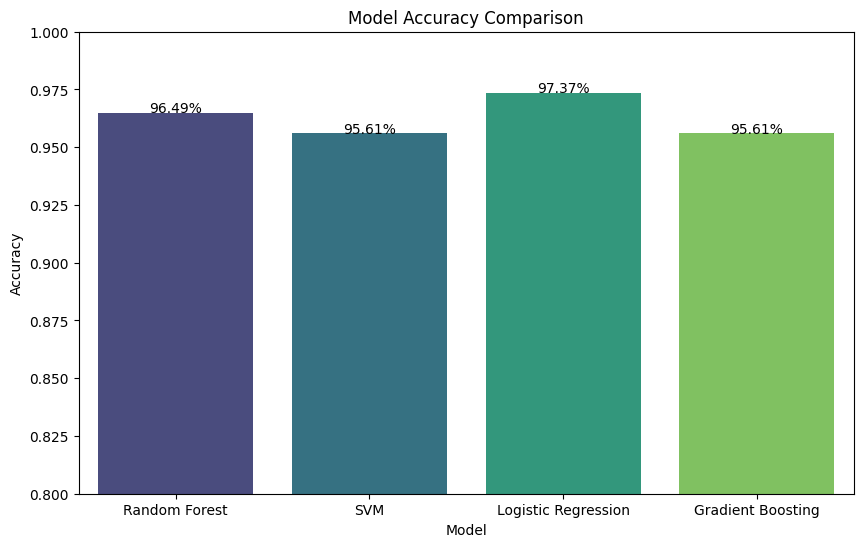

In [52]:
# Collect the accuracy scores for each model
models = ['Random Forest', 'SVM',
          'Logistic Regression', 'Gradient Boosting']
accuracy_scores = [rf_acc, svm_acc, lr_acc, gb_acc]

# Create a DataFrame for plotting
accuracy_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracy_scores
})

# Plot the bar plot
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x='Model', y='Accuracy',
                       data=accuracy_df, palette='viridis',
                       hue='Model', legend=False)
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0.8, 1.0) # Set appropriate limits for accuracy

# Add accuracy percentages on top of the bars
for index, row in accuracy_df.iterrows():
    bar_plot.text(row.name, row.Accuracy, f'{row.Accuracy:.2%}',
                  color='black', ha="center")

plt.show()

In [58]:
# Create a DataFrame to store model performance metrics
model_performance_df = pd.DataFrame({
    'Model': ['Random Forest', 'SVM', 'Logistic Regression', 'Gradient Boosting'],
    'Accuracy': [rf_acc, svm_acc, lr_acc, gb_acc],
    'F1 Score': [rf_f1, svm_f1, lr_f1, gb_f1],
    'AUC Score': [rf_auc, svm_auc, lr_auc, gb_auc],
    'Precision': [rf_precision, svm_precision, lr_precision, gb_precision],
    'Recall': [rf_recall, svm_recall, lr_recall, gb_recall]
})

# Display the performance table
print("Model Performance Comparison:")
display(model_performance_df)

# Determine the best performing model based on Accuracy
best_model_name = model_performance_df.loc[model_performance_df['Accuracy'].idxmax()]['Model']
print('----------------------------------------------------------------------------')
print(f"Overall, the best performing model based on Accuracy is: {best_model_name}")
print('----------------------------------------------------------------------------')

Model Performance Comparison:


,Model,Accuracy,F1 Score,AUC Score,Precision,Recall
0,Random Forest,0.964912,0.952381,0.958074,0.975610,0.930233
1,SVM,0.956140,0.942529,0.955617,0.931818,0.953488
2,Logistic Regression,0.973684,0.964706,0.969702,0.976190,0.953488
3,Gradient Boosting,0.956140,0.941176,0.951032,0.952381,0.930233


----------------------------------------------------------------------------
Overall, the best performing model based on Accuracy is: Logistic Regression
----------------------------------------------------------------------------
